In [101]:
import pandas as pd
import xgboost
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, max_error
import matplotlib
from xgboost import cv
import numpy as np

In [84]:
#prepare data for training
train_keys = ['% спек', '% марка Ж', '% кокс.', 'Оборот печей, ч',
       'Помол, %', 'Пыль, %', 'Влага, %', 'Зола, %', 'Летуч., %',
       'Мд. Серы, %', 'Пласт. слой, мм', 'R0', 'σ', 'Vt', 'I', 'Io', 'SI',
       'КТЦ эксп.', 'MF', 'MF_spec', 'MF_otosh', 'CSR_carb']
data = pd.read_excel("aligned_b1.xlsx")
#check zeroes
print(data.describe())
print(data.isnull().sum(axis = 0))
#fill NA by mean
for i,zeroes in enumerate(data.isnull().sum(axis = 0)):
    if zeroes>=1 and zeroes*100/len(data)<15:
        data.iloc[:, i].fillna((data.iloc[:, i].mean()), inplace=True)
    elif zeroes*100/len(data)>=15:
        print("!!!!!!! zeroes > 15 % !!!!!!!!!!")
        print(data.columns[i])
#fill NA by MICE imputation
# data_MICE = data.copy()
# for i,zeroes in enumerate(data_MICE.isnull().sum(axis = 0)):
#     if zeroes>=1 and zeroes*100/len(data_MICE)<15:
        

            % спек    % марка Ж      % кокс.  Оборот печей, ч     Помол, %  \
count  1712.000000  1712.000000  1712.000000      1699.000000  1711.000000   
mean     48.076869    27.060222    45.250000        18.240082    75.655523   
std       3.313924     3.743619     7.122334         0.855952     0.862956   
min      38.000000    14.800000    23.000000        16.500000    71.700000   
25%      46.000000    25.000000    40.000000        17.500000    75.200000   
50%      48.000000    26.800000    47.000000        18.000000    75.600000   
75%      50.500000    29.000000    50.000000        18.750000    75.900000   
max      56.500000    53.000000    62.000000        32.500000    81.400000   

           Пыль, %     Влага, %      Зола, %    Летуч., %  Мд. Серы, %  ...  \
count  1711.000000  1711.000000  1711.000000  1710.000000  1704.000000  ...   
mean     39.079836     9.192519     8.465108    25.434269     0.559138  ...   
std       0.994680     0.612828     0.417446     0.451492   

In [85]:
# #train
# split data
import warnings
warnings.filterwarnings('ignore')
for target in ["M25", "M10"]:
    train, test = train_test_split(data, test_size=0.1)
    features_train = train[train_keys]
    targets_train = train[target]
    features_test = test[train_keys]
    targets_test = test[target]
    alg = xgboost.XGBRegressor()
    alg.fit(features_train,targets_train)
    model_name = "xgboost_"+target
    # print("predict")
    predictions = alg.predict(features_test)
    r2score = r2_score(targets_test, predictions)
    r2score_random = r2_score(targets_test, data[target].sample(n=len(targets_test)))
    me = max_error(targets_test, predictions)
    me_random = max_error(targets_test, data[target].sample(n=len(targets_test)))
    mape = mean_absolute_percentage_error(targets_test, predictions)
    mape_random = mean_absolute_percentage_error(targets_test, data[target].sample(n=len(targets_test)))
    mse =mean_squared_error(targets_test, predictions)
    mse_random = mean_squared_error(targets_test, data[target].sample(n=len(targets_test)))
    mae = mean_absolute_error(targets_test, predictions)
    mae_random = mean_absolute_error(targets_test, data[target].sample(n=len(targets_test)))
    print(model_name)
    print("R2", "MSE", "MAE", "ME", "MAPE")
    print('%.3f' % r2score, '%.3f' % mse, '%.3f' % mae, '%.3f' % me, '%.3f' % mape)
    print("R2_random", "MSE_random",  "MAE_random",  "ME_random",  "MAPE_random")
    print('%.3f' % r2score_random, '%.3f' % mse_random, '%.3f' % mae_random, '%.3f' % me_random, '%.3f' % mape_random)
#     #get feature importances
#     feature_important = alg.get_booster().get_score(importance_type='weight')
#     keys = list(feature_important.keys())
#     values = list(feature_important.values())
#     data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
#     data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features


xgboost_M25
R2 MSE MAE ME MAPE
0.528 0.091 0.233 1.307 0.003
R2_random MSE_random MAE_random ME_random MAPE_random
-1.044 0.350 0.411 2.400 0.005
xgboost_M10
R2 MSE MAE ME MAPE
-0.180 0.067 0.211 0.702 0.030
R2_random MSE_random MAE_random ME_random MAPE_random
-0.756 0.139 0.293 1.000 0.039


In [76]:
# cross validation
import warnings
warnings.filterwarnings('ignore')
metrics_dict = {key: [] for key in ["model_name", "r2", "neg_mean_squared_error", "neg_mean_absolute_error", "max_error", "neg_mean_absolute_percentage_error"]}
# metrics = {"r2":"r2", "neg_mean_squared_error":"mse"}
# print(sklearn.metrics.SCORERS.keys())
for target in ["M25", "M10"]:
    train = data
    features_train = train[train_keys]
    targets_train = np.array(train[target])
    model = xgboost.XGBRegressor()
    kfold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    metrics_dict["model_name"].append("cross_val_"+target)
    for score in ["r2", "neg_mean_squared_error", "neg_mean_absolute_error", "max_error", "neg_mean_absolute_percentage_error"]:
        scores = cross_val_score(model,features_train, targets_train, scoring=score, cv=kfold)
        scores=np.absolute(scores)
        # force scores to be positive
        metrics_dict[score]. append(scores.mean())
#         print('Mean '+score+': %.3f (%.3f)' % (scores.mean(), scores.std()) )
metrics_data = pd.DataFrame.from_dict(metrics_dict)
print(metrics_data)

      model_name        r2  neg_mean_squared_error  neg_mean_absolute_error  \
0  cross_val_M25  0.431625                0.097078                 0.236576   
1  cross_val_M10  0.099868                0.064993                 0.196100   

   max_error  neg_mean_absolute_percentage_error  
0   1.118322                            0.002650  
1   0.875253                            0.027516  


{'MF_spec': 33.0, 'Пласт. слой, мм': 81.0, 'I': 85.0, '% кокс.': 87.0, 'Оборот печей, ч': 105.0, 'Vt': 107.0, 'КТЦ эксп.': 109.0, 'CSR_carb': 109.0, 'MF_otosh': 115.0, 'MF': 117.0, 'SI': 128.0, 'Мд. Серы, %': 132.0, 'Io': 139.0, 'R0': 149.0, 'σ': 164.0, '% марка Ж': 197.0, 'Летуч., %': 235.0, 'Зола, %': 243.0, '% спек': 270.0, 'Влага, %': 300.0, 'Пыль, %': 316.0, 'Помол, %': 369.0}
     model_name        r2  neg_mean_squared_error  neg_mean_absolute_error  \
0   xgboost_M10  0.086884                0.074249                 0.210665   
1      top3_M10  0.310449                0.089127                 0.232823   
2      top4_M10  0.291482                0.087716                 0.231032   
3      top5_M10  0.281986                0.087071                 0.229092   
4      top6_M10  0.174698                0.079850                 0.219833   
5      top7_M10  0.101649                0.073709                 0.210756   
6      top8_M10  0.052329                0.069382                 0.2

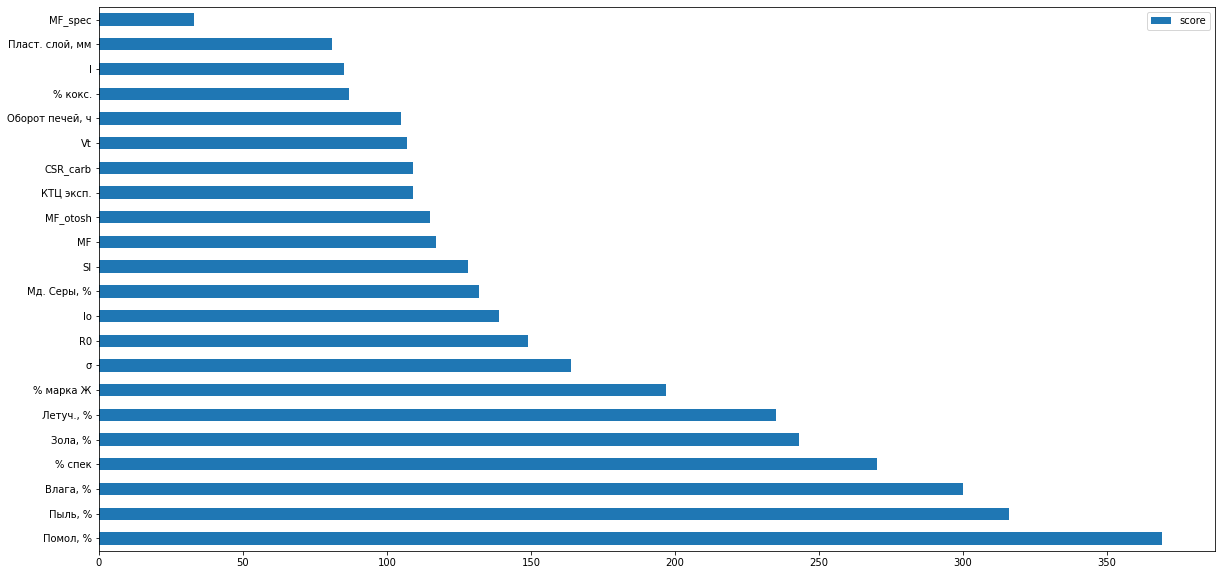

In [95]:
# M10 and feature importances
import warnings
warnings.filterwarnings('ignore')
metrics_dict = {key: [] for key in ["model_name", "r2", "neg_mean_squared_error", "neg_mean_absolute_error", "max_error", "neg_mean_absolute_percentage_error"]}
for target in ["M10"]:
    train, test = train_test_split(data, test_size=0.1)
    features_train = train[train_keys]
    targets_train = train[target]
    features_test = test[train_keys]
    targets_test = test[target]
    alg = xgboost.XGBRegressor()
    alg.fit(features_train,targets_train)
    metrics_dict["model_name"].append("xgboost_"+target)
    # print("predict")
    predictions = alg.predict(features_test)        
    r2score = r2_score(targets_test, predictions)
    metrics_dict['r2'].append(r2score)
    r2score_random = r2_score(targets_test, data[target].sample(n=len(targets_test)))
    me = max_error(targets_test, predictions)
    metrics_dict["max_error"].append(me)
    me_random = max_error(targets_test, data[target].sample(n=len(targets_test)))
    mape = mean_absolute_percentage_error(targets_test, predictions)
    metrics_dict["neg_mean_absolute_percentage_error"].append(mape)
    mape_random = mean_absolute_percentage_error(targets_test, data[target].sample(n=len(targets_test)))
    mse =mean_squared_error(targets_test, predictions)
    metrics_dict["neg_mean_squared_error"].append(mse)
    mse_random = mean_squared_error(targets_test, data[target].sample(n=len(targets_test)))
    mae = mean_absolute_error(targets_test, predictions)
    metrics_dict["neg_mean_absolute_error"].append(mae)
    mae_random = mean_absolute_error(targets_test, data[target].sample(n=len(targets_test)))
#     print(model_name)
#     print("R2", "MSE", "MAE", "ME", "MAPE")
#     print('%.3f' % r2score, '%.3f' % mse, '%.3f' % mae, '%.3f' % me, '%.3f' % mape)
#     print("R2_random", "MSE_random",  "MAE_random",  "ME_random",  "MAPE_random")
#     print('%.3f' % r2score_random, '%.3f' % mse_random, '%.3f' % mae_random, '%.3f' % me_random, '%.3f' % mape_random)
    feature_important = alg.get_booster().get_score(importance_type='weight')
    keys = list(feature_important.keys())
    values = list(feature_important.values())
    data_features = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
    data_features.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features
    #get model for top 10 features
    sorted_feature_important = {k: v for k, v in sorted(feature_important.items(), key=lambda item: item[1])}
    print(sorted_feature_important)
    for i in range(3, len(sorted_feature_important)+1):
        metrics_dict["model_name"].append("top"+str(i)+"_"+target)
        new_train_keys = [k for k, v in sorted(feature_important.items(), key=lambda item: item[1])][-i:]
        features_train = data[new_train_keys]
        targets_train = np.array(data[target])
        model = xgboost.XGBRegressor()
        kfold = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
        # evaluate model
        for score in ["r2", "neg_mean_squared_error", "neg_mean_absolute_error", "max_error", "neg_mean_absolute_percentage_error"]:
            scores = cross_val_score(model,features_train, targets_train, scoring=score, cv=kfold)
            scores=np.absolute(scores)
            # force scores to be positive
            metrics_dict[score]. append(scores.mean())
metrics_data = pd.DataFrame.from_dict(metrics_dict)
print(metrics_data)